# Import modules

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from PIL import Image
import cv2
import os
from torchinfo import summary
import matplotlib.pyplot as plt
import scipy.ndimage
import datetime
from tqdm.auto import tqdm
import random

c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function definition for euclidean distance calculation using tensors

# Load pre-trained ResNet model and inspect architecture

In [2]:
m = models.resnet50(pretrained=True)
m.eval()

summary(m, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"],
        # verbose=2
        )

c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    │ 

# Extract feature maps from intermediate layers

## Method 1

In [3]:
train_nodes, eval_nodes = get_graph_node_names(m)
for node in eval_nodes:
    print(node)

x
conv1
bn1
relu
maxpool
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer1.0.relu_1
layer1.0.conv3
layer1.0.bn3
layer1.0.downsample.0
layer1.0.downsample.1
layer1.0.add
layer1.0.relu_2
layer1.1.conv1
layer1.1.bn1
layer1.1.relu
layer1.1.conv2
layer1.1.bn2
layer1.1.relu_1
layer1.1.conv3
layer1.1.bn3
layer1.1.add
layer1.1.relu_2
layer1.2.conv1
layer1.2.bn1
layer1.2.relu
layer1.2.conv2
layer1.2.bn2
layer1.2.relu_1
layer1.2.conv3
layer1.2.bn3
layer1.2.add
layer1.2.relu_2
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.relu_1
layer2.0.conv3
layer2.0.bn3
layer2.0.downsample.0
layer2.0.downsample.1
layer2.0.add
layer2.0.relu_2
layer2.1.conv1
layer2.1.bn1
layer2.1.relu
layer2.1.conv2
layer2.1.bn2
layer2.1.relu_1
layer2.1.conv3
layer2.1.bn3
layer2.1.add
layer2.1.relu_2
layer2.2.conv1
layer2.2.bn1
layer2.2.relu
layer2.2.conv2
layer2.2.bn2
layer2.2.relu_1
layer2.2.conv3
layer2.2.bn3
layer2.2.add
layer2.2.relu_2
layer2.3.conv1
layer2.3.bn1
l

In [4]:
return_nodes = {
    # node_name: user-specified key for output dict
    'layer1.2.relu_2': 'layer1_output',
    'layer2.3.relu_2': 'layer2_output',
    'layer3.5.relu_2': 'layer3_output',
    'layer4.2.relu_2': 'layer4_output',
}

feature_extractor = create_feature_extractor(m, return_nodes=return_nodes)

# test feature extraction
image = torch.rand(1, 3, 224, 224).to('cuda')
with torch.no_grad():
    features = feature_extractor(image)

for k, v in features.items():
    print(k, v.shape)


layer1_output torch.Size([1, 256, 56, 56])
layer2_output torch.Size([1, 512, 28, 28])
layer3_output torch.Size([1, 1024, 14, 14])
layer4_output torch.Size([1, 2048, 7, 7])


## Method 2

In [5]:
for name, module in m.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.conv2
layer1.0.bn2
layer1.0.conv3
layer1.0.bn3
layer1.0.relu
layer1.0.downsample
layer1.0.downsample.0
layer1.0.downsample.1
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.conv2
layer1.1.bn2
layer1.1.conv3
layer1.1.bn3
layer1.1.relu
layer1.2
layer1.2.conv1
layer1.2.bn1
layer1.2.conv2
layer1.2.bn2
layer1.2.conv3
layer1.2.bn3
layer1.2.relu
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.conv2
layer2.0.bn2
layer2.0.conv3
layer2.0.bn3
layer2.0.relu
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.conv2
layer2.1.bn2
layer2.1.conv3
layer2.1.bn3
layer2.1.relu
layer2.2
layer2.2.conv1
layer2.2.bn1
layer2.2.conv2
layer2.2.bn2
layer2.2.conv3
layer2.2.bn3
layer2.2.relu
layer2.3
layer2.3.conv1
layer2.3.bn1
layer2.3.conv2
layer2.3.bn2
layer2.3.conv3
layer2.3.bn3
layer2.3.relu
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.conv2
layer3.0.bn2
layer3.0.conv

In [6]:
# Define a hook function to capture the output
def hook_fn(module, input, output):
    # Store the output in an attribute of the module
    module.feature_map = output
    
# Choose a layer from which to extract the feature map.
layer2 = m.layer2[-1]
layer3 = m.layer3[-1]

# Register the forward hook on the selected layer
hook_handle_layer2 = layer2.register_forward_hook(hook_fn)
hook_handle_layer3 = layer3.register_forward_hook(hook_fn)

# Create a dummy input tensor (batch size 1, 3 colour channels, 224x224 pixels)
input_tensor = torch.randn(3, 3, 224, 224).to('cuda')

# Perform a forward pass through the model
with torch.no_grad():
    output = m(input_tensor)

# After the forward pass, the feature map from the hook is stored in the layer attribute
print("Feature map shape from layer2:", layer2.feature_map.shape)
print("Feature map shape from layer3:", layer3.feature_map.shape)

# It is good practice to remove the hook when it is no longer needed
hook_handle_layer2.remove()
hook_handle_layer3.remove()

Feature map shape from layer2: torch.Size([3, 512, 28, 28])
Feature map shape from layer3: torch.Size([3, 1024, 14, 14])


# PatchCore and FeatureExtractor class definition

In [7]:
class PatchCore:
    def __init__(self, feature_extractor, neighbourhood_size, subsample_size_percentage, device='cuda', batch_size=64):
        self.feature_extractor = feature_extractor
        self.neighbourhood_size = neighbourhood_size
        self.subsample_size_percentage = subsample_size_percentage
        self.device = device
        self.batch_size = batch_size
        
        self.memory_bank = None
        self.subsample_indices = None
    
    def neighbourhood_aggregation(self, features):
        pooling_layer = nn.AvgPool2d(kernel_size=self.neighbourhood_size, stride=1, padding=self.neighbourhood_size//2) 
        output = pooling_layer(features)
        return output

    def extract_features(self, images):
        self.feature_extractor.eval()
        features = []
        
        # covert list of images to batch
        images = torch.stack(images)
        
        # split batch into sub-batches
        sub_batches  = torch.split(images, self.batch_size, dim=0)
        
        with torch.no_grad():
            for i, sub_batch in enumerate(sub_batches): 
                # patches = self.extract_patches(image)
                sub_batch = sub_batch.to(self.device)
                patch_features = self.feature_extractor(sub_batch)
                
                layer_a_features = patch_features["layer2"]
                layer_b_features = patch_features["layer3"]
                
                # apply neighbourhood aggregation
                layer_a_features = self.neighbourhood_aggregation(layer_a_features).type(torch.float64)
                layer_b_features = self.neighbourhood_aggregation(layer_b_features).type(torch.float64)
                
                # upscale layer 3 feature maps to match dimensions of layer 2 feature maps
                layer_b_features = nn.Upsample(scale_factor=2, mode='bilinear')(layer_b_features)
                
                # concatenate layer 2 and layer 3 feature maps
                patch_features = torch.cat([layer_a_features, layer_b_features], dim=1)
                
                features.append(patch_features)
                # features.append(layer_a_features)
        
        features = torch.cat(features)          
        return features
    
    def build_memory_bank(self, normal_images):
        normal_features = self.extract_features(normal_images)
        # normal_features = self.neighbourhood_aggregation(normal_features)
        self.memory_bank = normal_features.view(normal_features.shape[0], -1).cpu().numpy() # shape: [N, H * W * C]
        self.memory_bank = np.array(self.memory_bank, dtype=np.float64) # ensures script can handle small float values
        # return self.memory_bank
    
    def initialize_subset(self):
        centroid = np.mean(self.memory_bank, axis=0, dtype=np.float64)
        
        # calculate pairwise distances between centroid and memory bank using tensors
        # centroid_tensor = torch.tensor(centroid, dtype=torch.float64).to(self.device)
        # memory_back_tensor = torch.tensor(self.memory_bank, dtype=torch.float64).to(self.device)
        # distances_test = torch.cdist(centroid_tensor.unsqueeze(0), memory_back_tensor).flatten()
              
        distances = euclidean_distances([centroid], self.memory_bank).flatten()
        farthest_point_index = np.argmax(distances)
        subset_indices = [farthest_point_index]
        return subset_indices
    
    def select_next_point(self, subset_indices):
        subset = self.memory_bank[subset_indices]
        distances_to_subset = euclidean_distances(self.memory_bank, subset)
        min_distances = np.min(distances_to_subset, axis=1)
        next_point_index = np.argmax(min_distances)
        return next_point_index
    
    def corset_subsampling(self):
        self.subsample_size = int(self.subsample_size_percentage * len(self.memory_bank))
        assert self.subsample_size > 0 and self.subsample_size <= len(self.memory_bank), "Subsample size must be between 1 and the number of features in the memory bank"
        # subset_indices = self.initialize_subset()
        
        # while len(subset_indices) < self.subsample_size:
        #     next_point_index = self.select_next_point(subset_indices)
        #     subset_indices.append(next_point_index)
        # self.subsample_indices = np.array(subset_indices)
        
        self.subsample_indices = self.minimax_coreset_selection(torch.tensor(self.memory_bank, dtype=torch.float64), self.subsample_size)
        
    @staticmethod
    def minimax_coreset_selection(features: torch.Tensor, coreset_size: int) -> torch.Tensor:
        """
        Select a coreset of features using a minimax (greedy k-center) facility location method.
        
        Args:
            features (torch.Tensor): A tensor of shape (N, D) where N is the number of feature patches
                and D is the feature dimensionality.
            coreset_size (int): The number of features to select as the coreset.
        
        Returns:
            torch.Tensor: A tensor containing the indices of the selected features (shape: (coreset_size,)).
        
        The algorithm works as follows:
            1. Randomly select an initial feature.
            2. For each iteration, select the feature that is farthest (in Euclidean distance)
            from its closest already–selected feature.
        """
        num_points = features.size(0)
        
        if coreset_size >= num_points:
            # If the coreset size is greater than or equal to available features, return all indices.
            return torch.arange(num_points)
        
        # Initialize list of selected indices (as Python list for now)
        selected_indices = []
        
        # Randomly choose the first index
        initial_idx = random.randint(0, num_points - 1)
        selected_indices.append(initial_idx)
        
        # Compute distances from all points to the first selected feature.
        # Using squared Euclidean distances for efficiency.
        diff = features - features[initial_idx]
        distances = (diff ** 2).sum(dim=1)
        
        # Greedily select the rest of the coreset points.
        for _ in range(1, coreset_size):
            # Choose the point with the maximum distance from any selected point.
            farthest_idx = torch.argmax(distances).item()
            selected_indices.append(farthest_idx)
            
            # Update the distances: for each point, keep the minimum distance to any selected point.
            diff = features - features[farthest_idx]
            new_distances = (diff ** 2).sum(dim=1)
            distances = torch.minimum(distances, new_distances)
        
        return selected_indices
    
    def detect_anomalies(self, test_images, restrict_matching=False):
        test_features = self.extract_features(test_images)
        _, C_feat, H_feat, W_feat = test_features.shape
        subsampled_memory_bank = self.memory_bank[self.subsample_indices]
        
        if not(restrict_matching):
            reshaped_test_features = test_features.view(test_features.shape[0], test_features.shape[1], -1).permute(0, 2, 1) # shape: [Sn, H * W, C]
            reshaped_memory_bank = torch.tensor(subsampled_memory_bank, dtype=torch.float64).to(self.device).view(subsampled_memory_bank.shape[0], test_features.shape[1], test_features.shape[2] * test_features.shape[3]).permute(0, 2, 1)# shape: [N, H * W, C]
            reshaped_memory_bank = reshaped_memory_bank.reshape(-1, reshaped_memory_bank.shape[2]) # shape: [N * H * W, C]
            heatmap = np.zeros((test_features.shape[0],test_features.shape[2], test_features.shape[3]))
            
            for sample_idx in range(test_features.shape[0]):
                tf = reshaped_test_features[sample_idx]
                
                # Compute nearest neighbor distance (Euclidean)
                distances = torch.cdist(tf, reshaped_memory_bank)
                min_distances, x = torch.min(distances, dim=1)
                
                anomaly_map = min_distances.view(test_features.shape[2], test_features.shape[3])  # Shape: [H', W']
                heatmap[sample_idx] = anomaly_map.cpu().numpy()
        
        else:
            reshaped_test_features = test_features.view(test_features.shape[0], test_features.shape[1], -1).permute(0, 2, 1) # shape: [Sn, H * W, C]
            reshaped_memory_bank = torch.tensor(subsampled_memory_bank, dtype=torch.float64).to(self.device).view(-1, C_feat, H_feat * W_feat).permute(2, 0, 1) # shape: [H * W, N, C]
            heatmap = np.zeros((test_features.shape[0],test_features.shape[2], test_features.shape[3]))
            
            for sample_idx in range(test_features.shape[0]):
                tf = reshaped_test_features[sample_idx].unsqueeze(1)
                
                # Compute nearest neighbor distance (Euclidean)
                distances = torch.cdist(tf, reshaped_memory_bank)
                distances = distances.squeeze(1)
                min_distances, _ = torch.min(distances, dim=1)
                
                anomaly_map = min_distances.view(H_feat, W_feat)  # Shape: [H', W']
                heatmap[sample_idx] = anomaly_map.cpu().numpy()

        # reshaped_memory_bank = subsampled_memory_bank.reshape(subsampled_memory_bank.shape[0], test_features.shape[1], test_features.shape[2] , test_features.shape[3])
        # heatmap = np.zeros((test_features.shape[0],test_features.shape[2], test_features.shape[3]))
        # for sample_idx in range(test_features.shape[0]):
            
        #     # build heatmap
        #     for i in range(test_features.shape[2]):
        #         for j in range(test_features.shape[3]):
        #             tf = test_features[sample_idx, :, i, j].cpu().numpy()
        #             tf = np.array(tf, dtype=np.float64)
        #             ssmb = reshaped_memory_bank[:, :, i, j]
        #             distances_to_memory_bank = euclidean_distances([tf], ssmb)
        #             anomaly_score = np.min(distances_to_memory_bank, axis=1)
        #             heatmap[sample_idx, i, j] = anomaly_score.item()
        
        # distances_to_memory_bank = euclidean_distances(test_features, subsampled_memory_bank)
        # anomaly_scores = np.min(distances_to_memory_bank, axis=1)
        return heatmap

class FeatureExtractor(nn.Module):
    def __init__(self, layers_to_hook:list = ["layer1", "layer2", "layer3", "layer4"]):
        super().__init__()
        self.resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        self.layers_to_hook = layers_to_hook
        
        for layer in self.layers_to_hook: 
            getattr(self.resnet50, layer)[-1].register_forward_hook(lambda mod, inp, out: self.hook_fn(mod, inp, out, layer))

        
    def hook_fn(self, module, input, output, layer_name):
        module.feature_map = output
        
    def forward(self, x):
        self.feature_maps = {}

        with torch.no_grad():
            out = self.resnet50(x)
            
        self.feature_maps = {layer: getattr(self.resnet50, layer)[-1].feature_map for layer in self.layers_to_hook}
            
        return self.feature_maps
            

In [8]:
# test feature extraction
image = torch.rand(3, 3, 224, 224).to('cuda')
# feature_extractor = FeatureExtractor(layers_to_hook=["layer2", "layer3"]).to('cuda')
feature_extractor = FeatureExtractor().to('cuda')
features = feature_extractor(image)
    
print (features['layer2'].shape)

torch.Size([3, 512, 28, 28])


# Load and preprocess images

In [9]:
# Load and preprocess images (for example purposes, use random noise as images)

transform = transforms.Compose([
    transforms.Resize((224*1, 224*1)),
    # transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), 
        ])

def load_images_from_folder(folder):
    images = []
    for filename in tqdm(os.listdir(folder)):
        # pil_image = Image.open(os.path.join(folder, filename))
        numpy_image = cv2.imread(os.path.join(folder, filename))
        
        pil_image = Image.fromarray(np.uint8(numpy_image))
        images.append(transform(pil_image))
        
    return images 

In [10]:
normal_images = load_images_from_folder(r'C:\Users\me1kox\Documents\Local scratch space\mvtec_anomaly_detection\bottle\train\good')

100%|██████████| 209/209 [00:03<00:00, 66.38it/s]


In [11]:
normal_images[0].shape

torch.Size([3, 224, 224])

torch.Size([224, 224, 3])


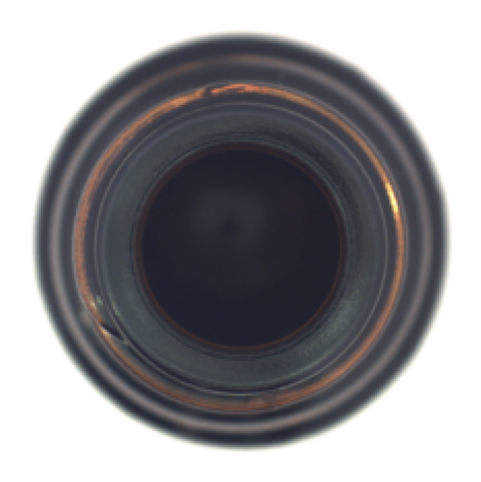

In [12]:
img_to_display = normal_images[6].permute(1, 2, 0)
print(img_to_display.shape)

img_to_display = img_to_display[:,:,[2,1,0]] # convert tensor image from BGR to RGB for display

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_to_display, cmap='gray')
ax.axis('off')
plt.show()

# Instantiate PatchCore

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained feature extractor
feature_extractor = FeatureExtractor().to(device)    

# Initialize PatchCore
patchcore = PatchCore(
                      feature_extractor=feature_extractor, 
                      neighbourhood_size=3, 
                      subsample_size_percentage=0.3, 
                      device=device
                      )

# Build memory bank

In [14]:
patchcore.build_memory_bank(normal_images)   

# Perform corset subsampling

In [15]:
patchcore.corset_subsampling()   

# Test anomaly detection on test images

In [16]:
test_images = load_images_from_folder(r'C:\Users\me1kox\Documents\Local scratch space\mvtec_anomaly_detection\bottle\test\broken_large')

100%|██████████| 20/20 [00:00<00:00, 69.82it/s]


torch.Size([224, 224, 3])


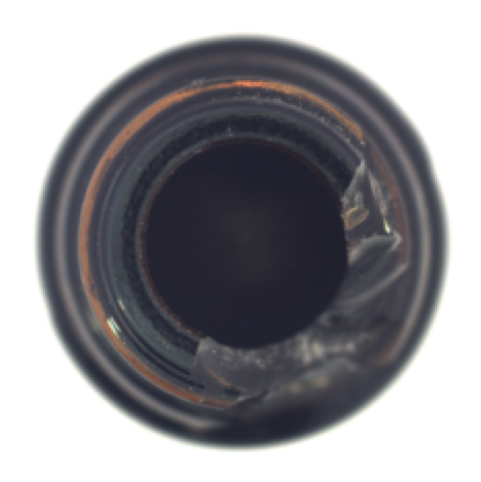

In [17]:
img_to_display = test_images[0].permute(1, 2, 0)
print(img_to_display.shape)


img_to_display = img_to_display[:,:,[2,1,0]] # convert tensor image from BGR to RGB for display

fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(img_to_display, cmap='gray')
ax.axis('off')
plt.show()

In [18]:
anomaly_maps = patchcore.detect_anomalies(test_images, restrict_matching=True)

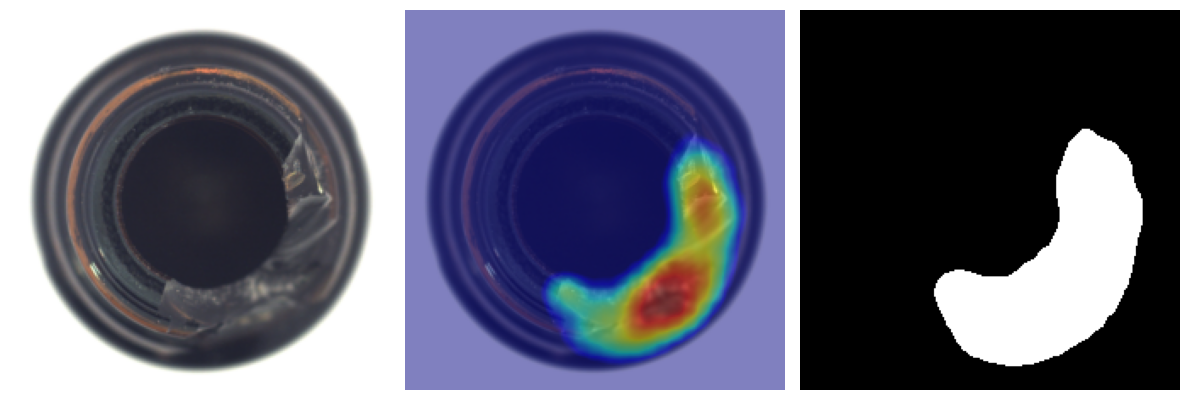

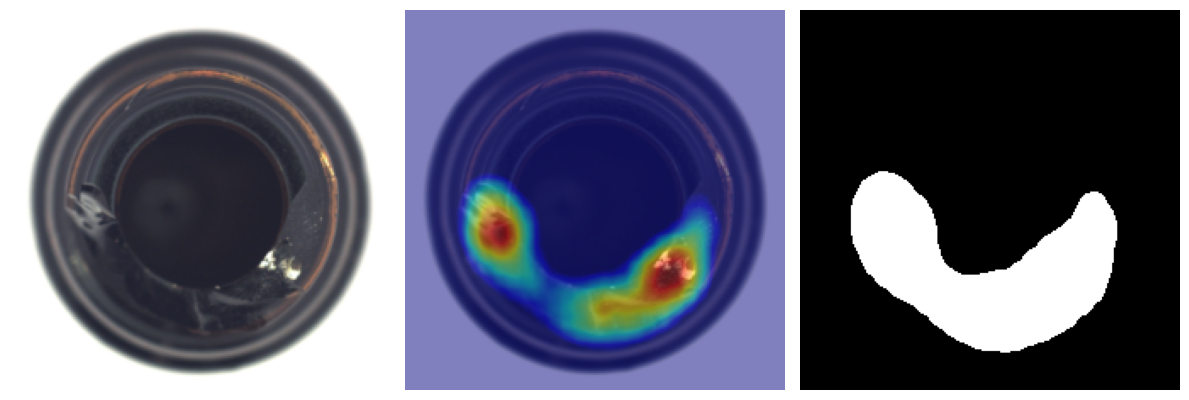

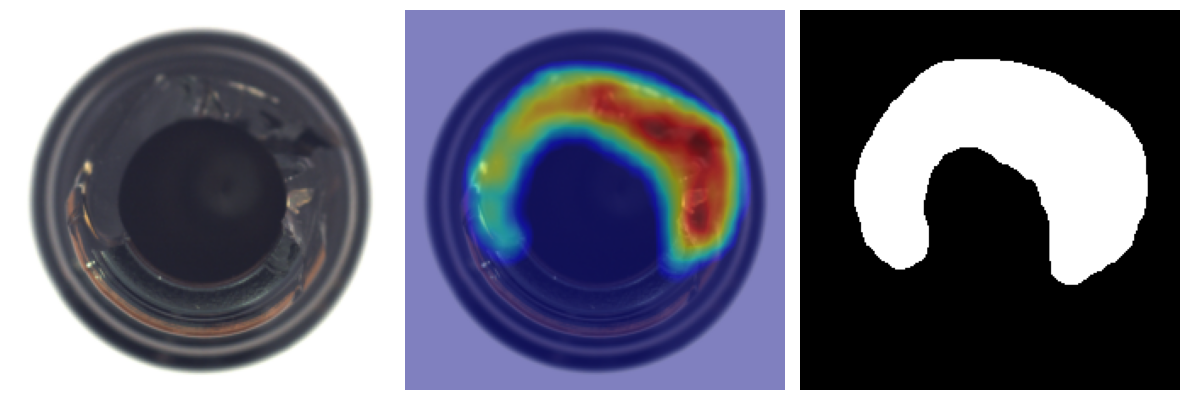

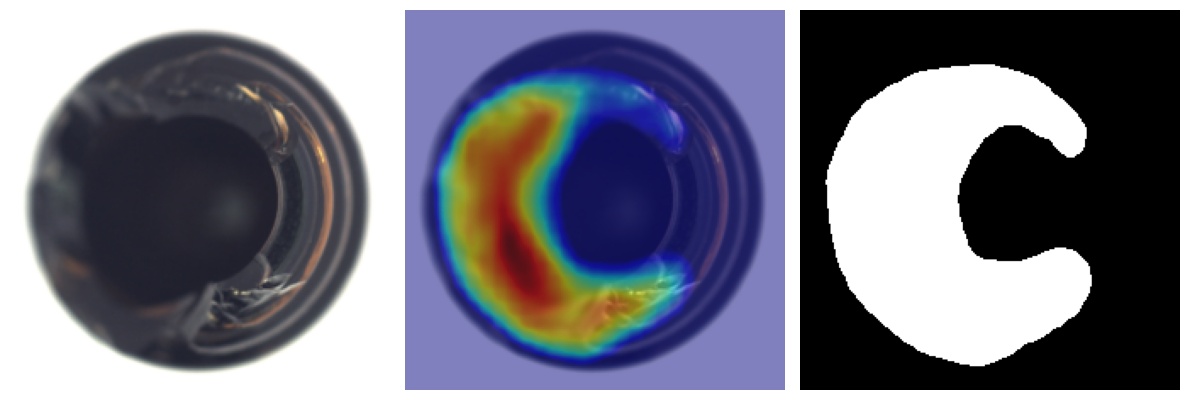

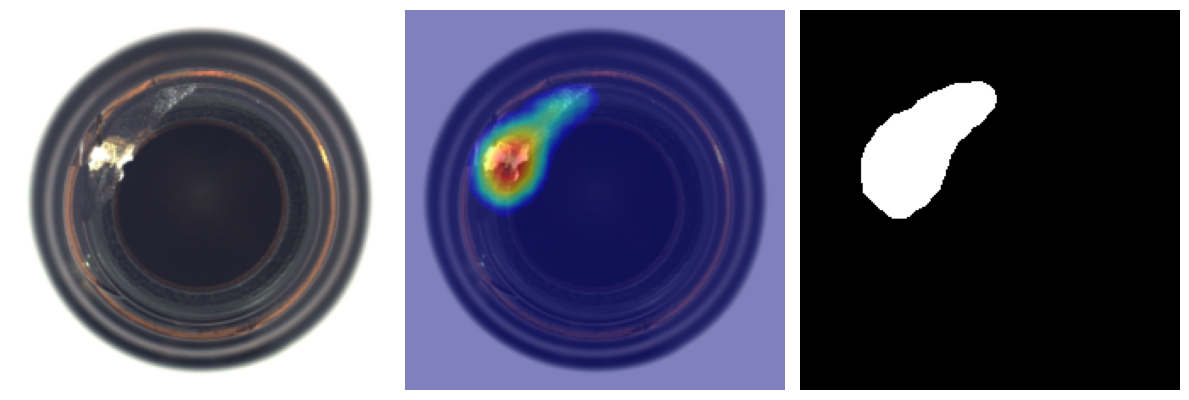

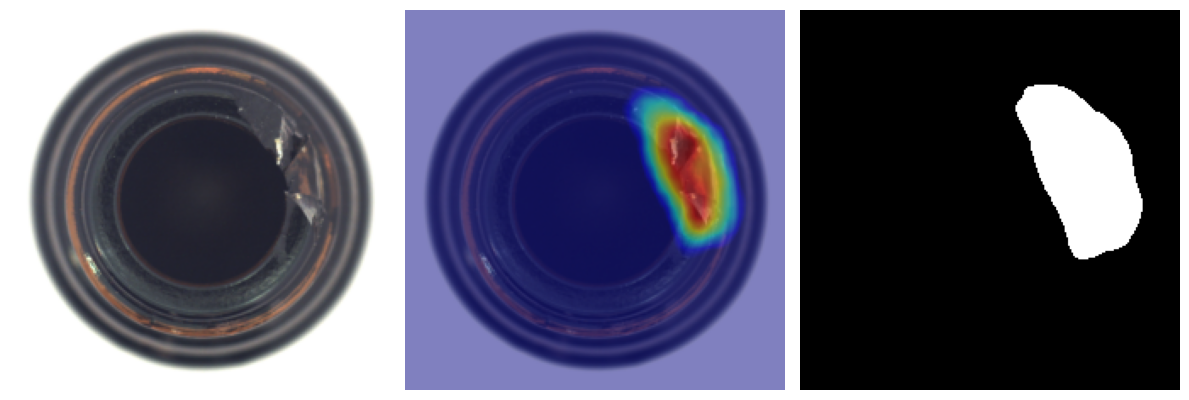

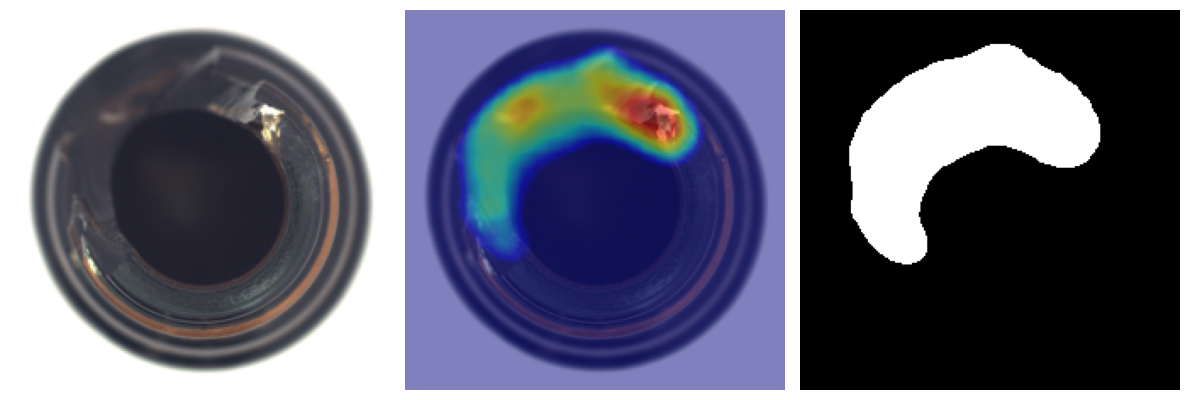

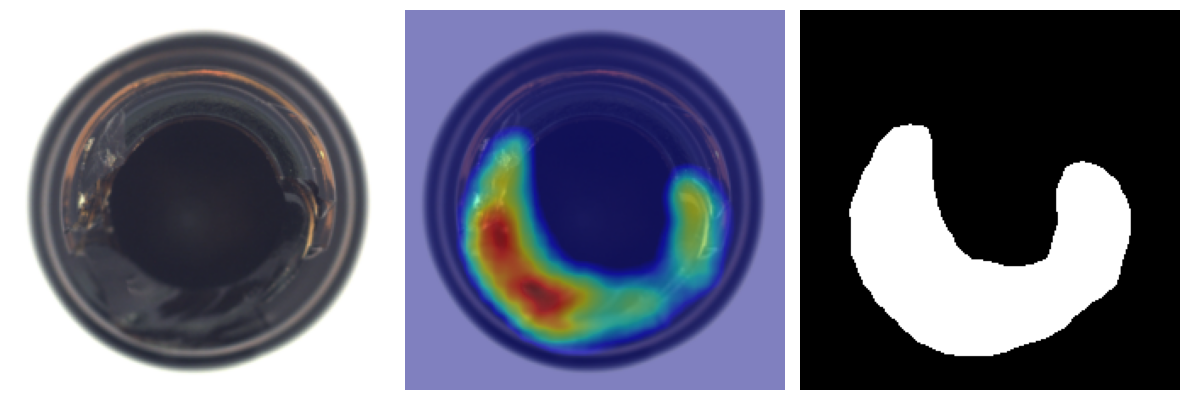

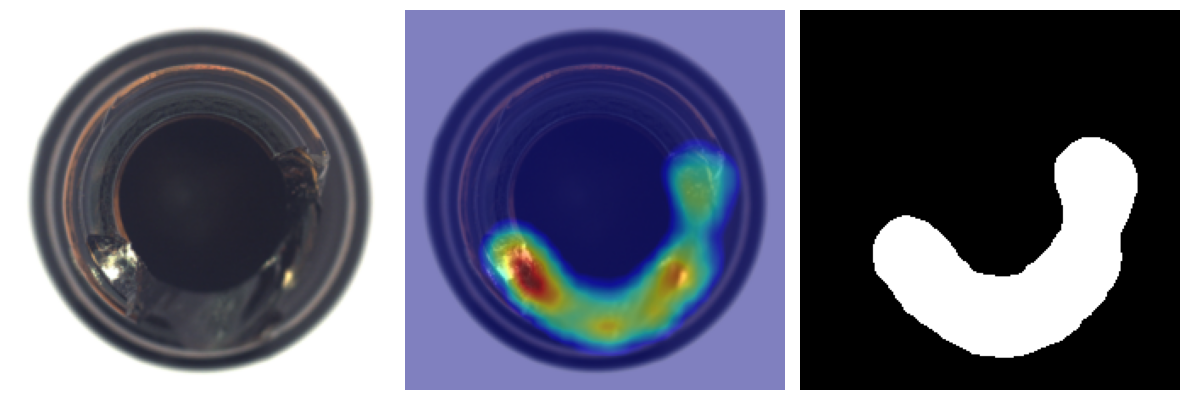

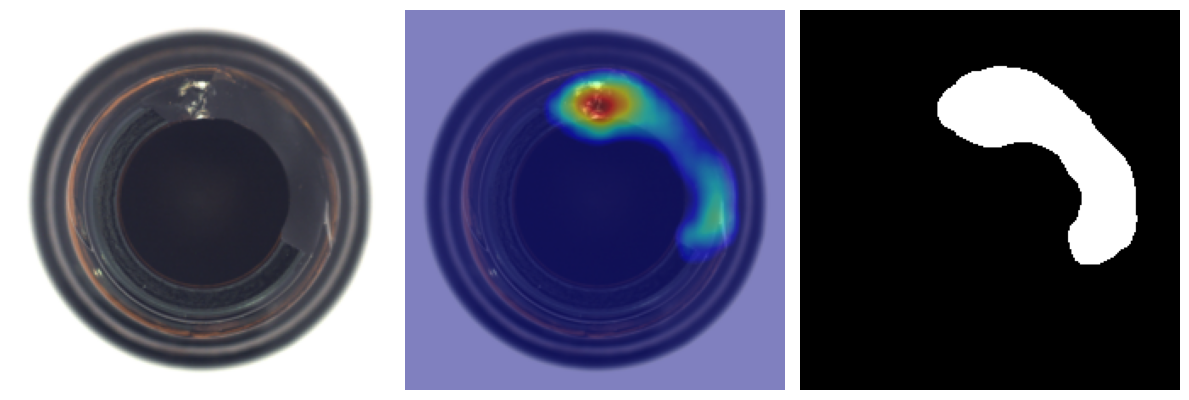

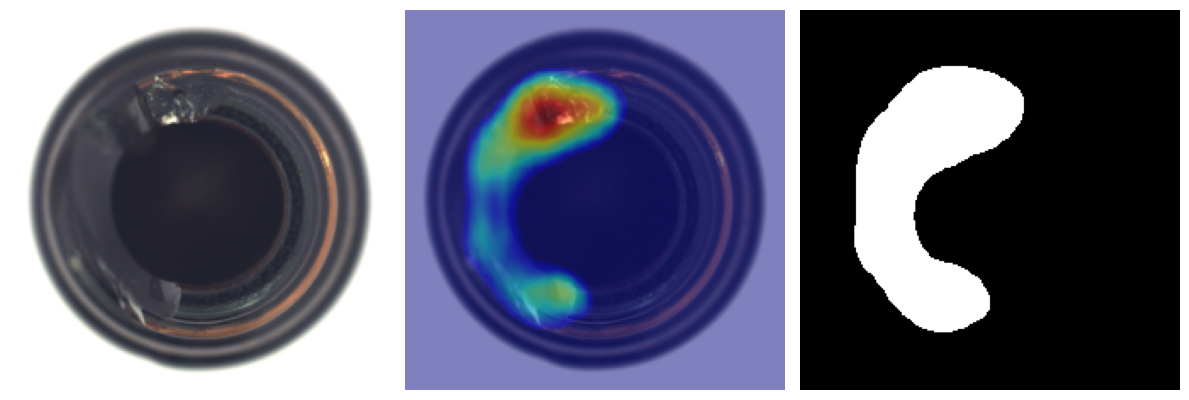

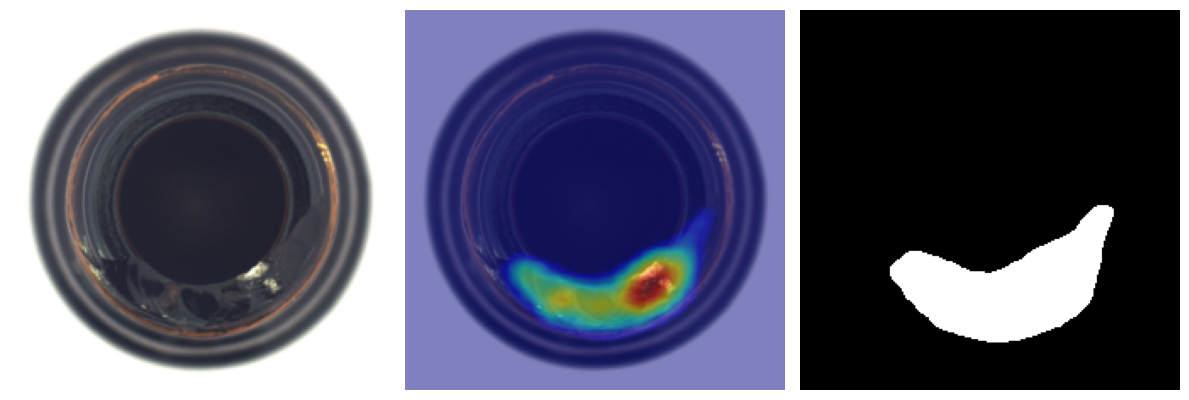

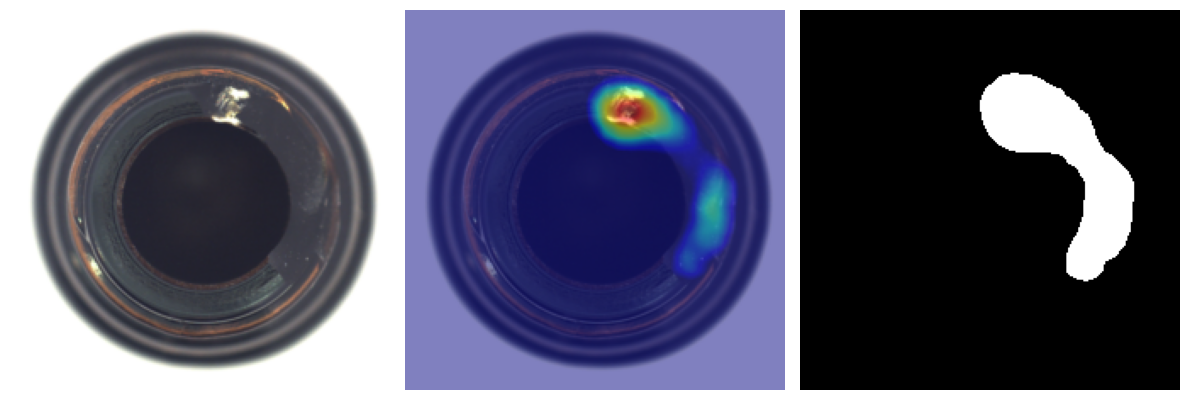

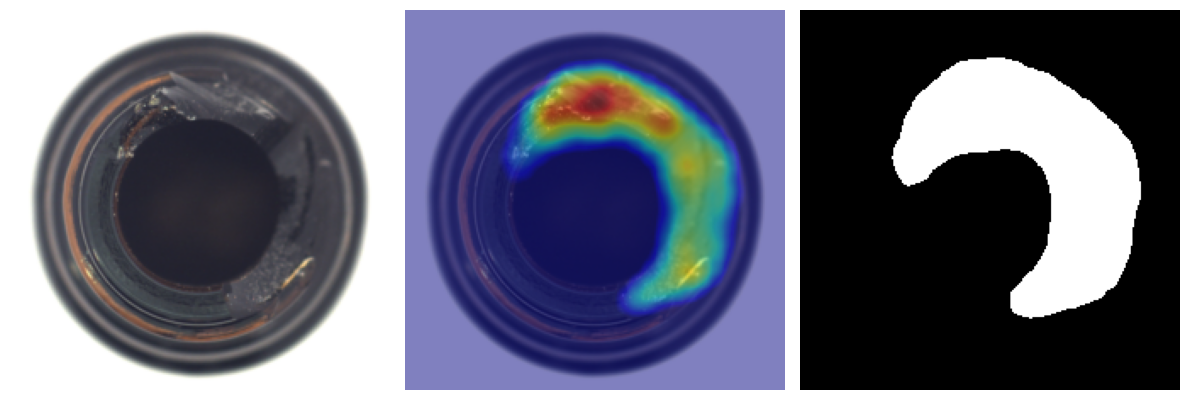

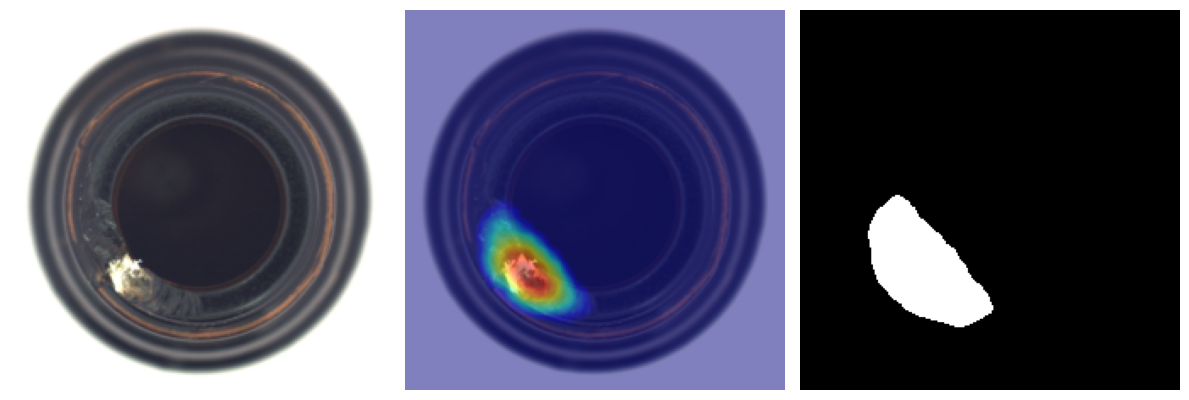

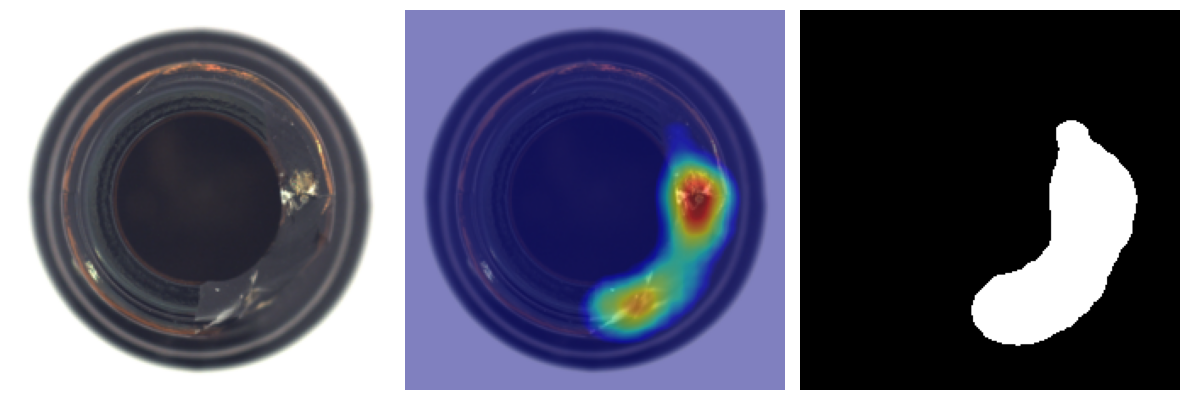

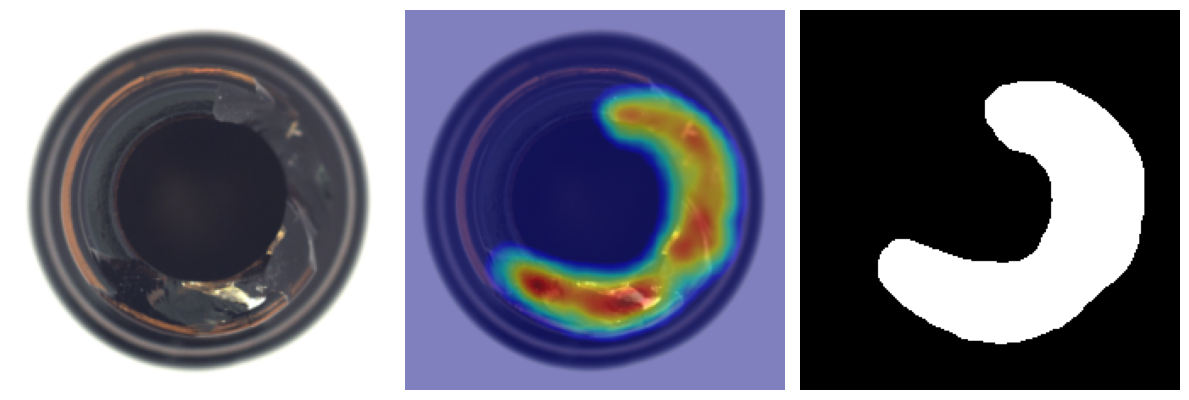

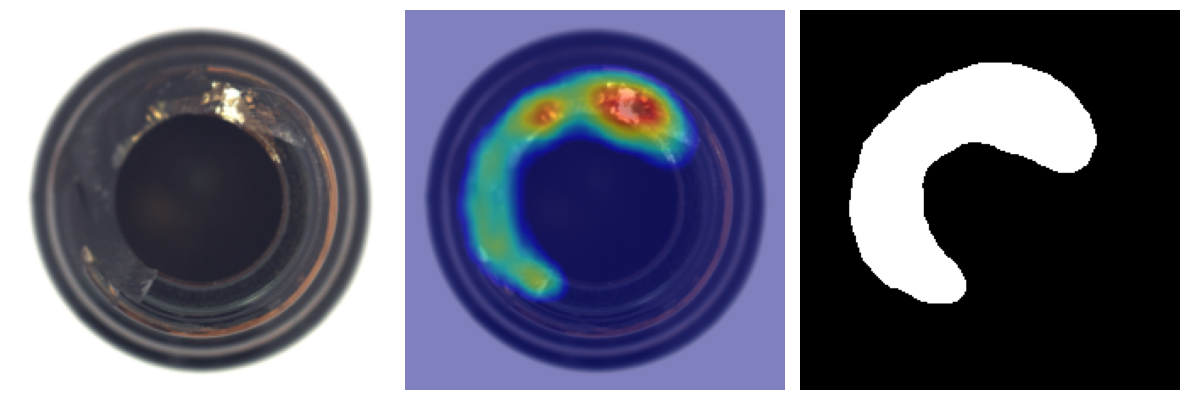

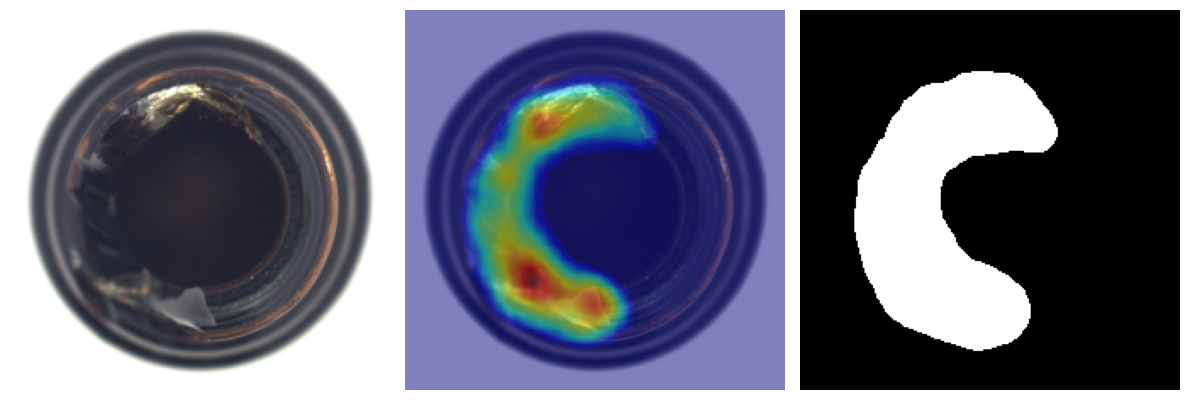

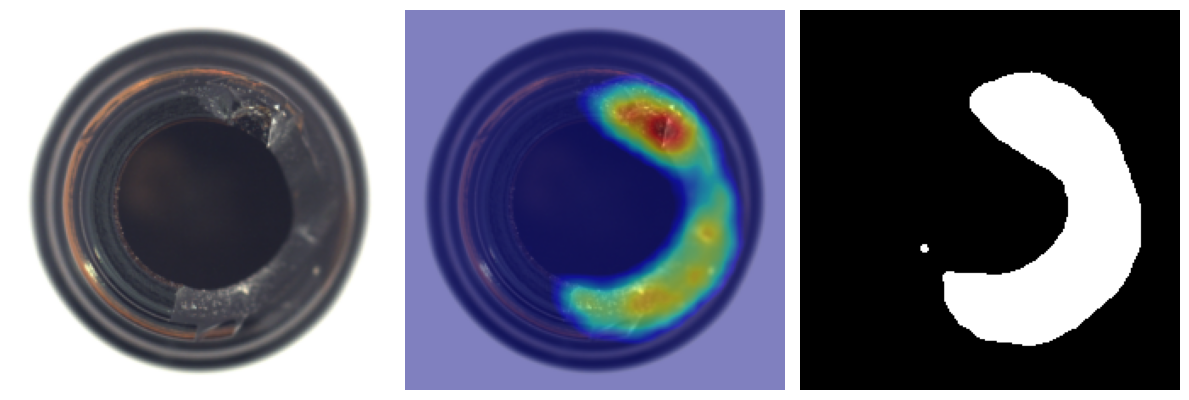

In [21]:
for idx, heatmap in enumerate(anomaly_maps):
    detection_threshold = np.max(heatmap) * 0.5

    heatmap = cv2.resize(heatmap, (test_images[idx].shape[1], test_images[idx].shape[2]), interpolation=cv2.INTER_CUBIC)
    mask = np.where(heatmap >= detection_threshold, 1, 0)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 8), dpi=100)
    
    img_to_display = test_images[idx].permute(1, 2, 0)
    img_to_display = img_to_display[:,:,[2,1,0]] # convert tensor image from BGR to RGB for display

    axs[0].imshow(img_to_display, cmap='gray')
    axs[1].imshow(img_to_display, cmap='gray')
    axs[1].imshow(heatmap, cmap='jet', alpha= 0.5, vmin=detection_threshold, vmax=np.max(heatmap))
    axs[2].imshow(mask, cmap='gray')

    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
    
